In [1]:
import numpy as np
import pandas as pd
from scipy.stats import iqr, scoreatpercentile
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
%matplotlib inline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge,HuberRegressor, PoissonRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

# Introduction

**We know that heatwave is the extended period of time when extremely high temperatures are observed relative to the climate of the location. In many literatures the severity of the heatwave is represented by the Excess Heat Factor (EHF) [Nairn et al., 2015](https://pubmed.ncbi.nlm.nih.gov/25546282/) and mathematically it is defined to be:**

$$EHF=EHI_{sig}*max(1, EHI_{accl})$$ 



where

$$EHI_{sig}=(T_i+T_{i+1}+T_{i+2})/3-T_{95}$$ 
$$EHI_{accl}=(T_i+T_{i+1}+T_{i+2})/3-(T_{i-1}+T_{i-2}+...+T_{i-30})/30$$ 




**$T_{95}$ is calculated by taking the 95th percentile of the $T_i$s of all historical possible days in database. $T_i$ of the day is found as the mean of the temperatures recorded on the day. Of course the measurements must be equally spaced. Then if we find out that for $T_i$ the EHF is a positive number, then the three days $T_i, T_{
i+1}, T_{i+2}$ are considered heatwave days.** 

**Then, the heatwave is considered severe if EHF>=EHF$_{85}$ where EHF$_{85}$ is 85th percentile of the positive EHFs throughout the years recorded in our table.**

# Data collection

**Using [Opendata meteo.be](https://opendata.meteo.be) the following temperature data was collected in csv format:**


*Cities: Brussels, Antwerp, Liege*

*Period: 1952-2021* 

*Frequency: Depending on year and location: hourly, every 3h, every 6h, etc.*

# Data cleaning and transformation

In [2]:
Brussels=pd.read_csv("./data/Brussels.csv")
Antwerp=pd.read_csv("./data/Antwerp.csv")
Liege=pd.read_csv("./data/Liege.csv")

In [3]:
Brussels.head()

,FID,the_geom,code,timestamp,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,...,wind_speed_unit,wind_direction,wind_peak_speed,humidity_relative,weather_current,pressure,pressure_station_level,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness
0,synop_data.6451.1952-01-01 00:00:00+00,POINT (50.896391 4.526765),6451,1952-01-01T00:00:00,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,90.0,NaN,NaN,61.0,1005.5,NaN,NaN,NaN,8.0
1,synop_data.6451.1952-01-01 03:00:00+00,POINT (50.896391 4.526765),6451,1952-01-01T03:00:00,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,50.0,1003.1,NaN,NaN,NaN,8.0
2,synop_data.6451.1952-01-01 06:00:00+00,POINT (50.896391 4.526765),6451,1952-01-01T06:00:00,2.0,2.0,3.0,3.0,NaN,NaN,...,NaN,250.0,NaN,NaN,51.0,1004.0,NaN,NaN,NaN,8.0
3,synop_data.6451.1952-01-01 09:00:00+00,POINT (50.896391 4.526765),6451,1952-01-01T09:00:00,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,270.0,NaN,NaN,21.0,1006.9,NaN,NaN,NaN,5.0
4,synop_data.6451.1952-01-01 12:00:00+00,POINT (50.896391 4.526765),6451,1952-01-01T12:00:00,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,260.0,NaN,NaN,25.0,1009.2,NaN,NaN,NaN,6.0


**As we are using only the information on temperature we need to keep only the timestamp and the temperature**

In [4]:
Brussels=Brussels[["timestamp", "temp"]]
Antwerp=Antwerp[["timestamp", "temp"]]
Liege=Liege[["timestamp", "temp"]]

In [5]:
Brussels.head()

,timestamp,temp
0,1952-01-01T00:00:00,3.0
1,1952-01-01T03:00:00,3.0
2,1952-01-01T06:00:00,3.0
3,1952-01-01T09:00:00,3.0
4,1952-01-01T12:00:00,4.0


In [6]:
cities=[Brussels, Antwerp, Liege]
for city in cities:
    city['timestamp_formatted']=pd.to_datetime(city['timestamp'])

In [7]:
Brussels.head()

,timestamp,temp,timestamp_formatted
0,1952-01-01T00:00:00,3.0,1952-01-01 00:00:00
1,1952-01-01T03:00:00,3.0,1952-01-01 03:00:00
2,1952-01-01T06:00:00,3.0,1952-01-01 06:00:00
3,1952-01-01T09:00:00,3.0,1952-01-01 09:00:00
4,1952-01-01T12:00:00,4.0,1952-01-01 12:00:00


In [8]:
Brussels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420595 entries, 0 to 420594
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   timestamp            420595 non-null  object        
 1   temp                 420261 non-null  float64       
 2   timestamp_formatted  420595 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 9.6+ MB


In [9]:
for city in cities:
    city['year']=city['timestamp_formatted'].dt.year
    city['month']=city['timestamp_formatted'].dt.month
    city['day']=city['timestamp_formatted'].dt.day
    city['hour']=city['timestamp_formatted'].dt.hour
    city.drop(labels=['timestamp','timestamp_formatted'], axis=1, inplace=True)

In [10]:
Brussels.head(10)

,temp,year,month,day,hour
0,3.0,1952,1,1,0
1,3.0,1952,1,1,3
2,3.0,1952,1,1,6
3,3.0,1952,1,1,9
4,4.0,1952,1,1,12
5,5.0,1952,1,1,15
6,3.0,1952,1,1,18
7,2.0,1952,1,1,21
8,3.0,1952,1,2,0
9,3.0,1952,1,2,3


In [11]:
Bru_summer=Brussels[Brussels['month'].isin([5,6,7,8])]

In [12]:
Ant_summer=Antwerp[Antwerp['month'].isin([5,6,7,8])]

In [13]:
Lie_summer=Liege[Liege['month'].isin([5,6,7,8])]

**Problems might arise with calculating the mean teperature of the day correctly**
1. Not enough observations 
2. Observations are not regularly spaced

# 1

**Here we find the days where the number of observations was less than 4**

In [14]:
pd.set_option('display.max_rows', 300)

In [15]:
Bru_count=Bru_summer.set_index(['year', 'month', 'day']).groupby(level=[0, 1, 2]).count()[['temp']]
Bru_count[Bru_count['temp']<4]

,,,temp
year,month,day,
1960,5,25,0


In [16]:
Ant_count=Ant_summer.set_index(['year', 'month', 'day']).groupby(level=[0, 1, 2]).count()[['temp']]
Ant_count[Ant_count['temp']<4]

,,,temp
year,month,day,
1964,8,18,0
1978,5,12,2


In [17]:
Lie_count=Lie_summer.set_index(['year', 'month', 'day']).groupby(level=[0, 1, 2]).count()[['temp']]
Lie_count[Lie_count['temp']<4]

temp
year month day      
1954 7     29      2
           30      2
1976 7     25      1

**Thus, we see that for Brussels there is only one day where we have no observation at all. For Antwerp, there are two days for which the number of observations is less than 4. For Liege, that number is only 3.**

# 2

**Here we check if the observations are regularly spaced (at least close to)**

In [18]:
Bru_summer=Bru_summer.reset_index().drop(columns=["index"])
Ant_summer=Ant_summer.reset_index().drop(columns=["index"])
Lie_summer=Lie_summer.reset_index().drop(columns=["index"])

In [19]:
Bru_summer['hour_unif']=Bru_summer['hour'].apply(lambda x: x/24)
Ant_summer['hour_unif']=Ant_summer['hour'].apply(lambda x: x/24)
Lie_summer['hour_unif']=Lie_summer['hour'].apply(lambda x: x/24)

In [20]:
pd.set_option('max_colwidth', None)

In [21]:
Bru_spread=Bru_summer.set_index(['year', 'month', 'day']).groupby(level=[0, 1, 2])[['hour_unif']].agg(iqr)
Bru_spread['measurements']=Bru_summer.set_index(['year', 'month', 'day']).groupby(level=[0, 1, 2])['hour'].apply(list)
Bru_spread.rename(columns={'hour_unif':'iqr'}, inplace=True)

In [22]:
Bru_spread[np.logical_or(Bru_spread['iqr']>0.6, Bru_spread['iqr']<0.4)]

,,,iqr,measurements
year,month,day,,
2004,6,3,0.25,"[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 21, 22, 23]"


In [23]:
Ant_spread=Ant_summer.set_index(['year', 'month', 'day']).groupby(level=[0, 1, 2])[['hour_unif']].agg(iqr)
Ant_spread['measurements']=Ant_summer.set_index(['year', 'month', 'day']).groupby(level=[0, 1, 2])['hour'].apply(list)
Ant_spread.rename(columns={'hour_unif':'iqr'}, inplace=True)

In [24]:
Ant_spread[np.logical_or(Ant_spread['iqr']>0.6, Ant_spread['iqr']<0.4)]

iqr  \
year month day             
1978 5     12   0.062500   
           13   0.312500   
1980 5     3    0.312500   
     7     26   0.312500   
     8     2    0.312500   
           3    0.312500   
           4    0.312500   
           5    0.312500   
           6    0.312500   
           7    0.312500   
           8    0.312500   
           9    0.312500   
           10   0.312500   
           11   0.312500   
           19   0.312500   
           20   0.312500   
1981 7     7    0.312500   
           8    0.312500   
           9    0.312500   
2004 6     3    0.250000   
2006 6     2    0.333333   

                                                                     measurements  
year month day                                                                     
1978 5     12                                                              [0, 3]  
           13                                              [6, 9, 12, 15, 18, 21]  
1980 5     3                                               [6, 9, 12, 15, 18, 21]  
     7     26                                              [6, 9, 12, 15, 18, 21]  
     8     2                                               [6, 9, 12, 15, 18, 21]  
           3                                               [6, 9, 12, 15, 18, 21]  
           4                                               [6, 9, 12, 15, 18, 21]  
           5                                               [6, 9, 12, 15, 18, 21]  
           6                                               [6, 9, 12, 15, 18, 21]  
           7                                               [6, 9, 12, 15, 18, 21]  
           8                                               [6, 9, 12, 15, 18, 21]  
           9                                               [6, 9, 12, 15, 18, 21]  
           10                                              [6, 9, 12, 15, 18, 21]  
           11                                              [6, 9, 12, 15, 18, 21]  
           19                                              [6, 9, 12, 15, 18, 21]  
           20                                              [6, 9, 12, 15, 18, 21]  
1981 7     7                                               [6, 9, 12, 15, 18, 21]  
           8                                               [6, 9, 12, 15, 18, 21]  
           9                                               [6, 9, 12, 15, 18, 21]  
2004 6     3                        [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 21, 22, 23]  
2006 6     2    [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [25]:
Lie_spread=Lie_summer.set_index(['year', 'month', 'day']).groupby(level=[0, 1, 2])[['hour_unif']].agg(iqr)
Lie_spread['measurements']=Lie_summer.set_index(['year', 'month', 'day']).groupby(level=[0, 1, 2])['hour'].apply(list)
Lie_spread.rename(columns={'hour_unif':'iqr'}, inplace=True)

In [26]:
Lie_spread[np.logical_or(Lie_spread['iqr']>0.6, Lie_spread['iqr']<0.4)]

iqr  \
year month day             
2004 5     26   0.375000   
           27   0.395833   
     6     3    0.250000   
           27   0.395833   
     7     30   0.375000   
     8     9    0.354167   

                                                                              measurements  
year month day                                                                              
2004 5     26           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19]  
           27     [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22]  
     6     3                                 [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 21, 22, 23]  
           27   [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]  
     7     30           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20]  
     8     9                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

**For Antwerp, although (6, 9, 12, 15, 18, 21) ignores the nighttime measurements we cannot interpolate from neighboring days as they come in rows. So, I would drop the year 1980, 1981. The other non-reliable temperatures can be interpolated from the neighboring days.**

# Daily mean computation, interpolation, dropping some years

In [27]:
Bru=Bru_summer.set_index(['year', 'month', 'day']).groupby(level=[0, 1, 2])[['temp']].mean()
Ant=Ant_summer.set_index(['year', 'month', 'day']).groupby(level=[0, 1, 2])[['temp']].mean()
Lie=Lie_summer.set_index(['year', 'month', 'day']).groupby(level=[0, 1, 2])[['temp']].mean()

In [28]:
Ant.drop([1980, 1981], level=0, axis=0, inplace=True)

In [29]:
Bru.loc[1960, 5, 25]=(Bru.xs((1960, 5, 24))+Bru.xs((1960, 5, 26)))/2
Bru.loc[2004, 6, 3]=(Bru.xs((2004, 6, 2))+Bru.xs((2004, 6, 4)))/2
Ant.loc[1964, 8, 18]=(Ant.xs((1964, 8, 17))+Ant.xs((1964, 8, 19)))/2
Ant.loc[1978, 5, 12]=(Ant.xs((1978, 5, 11))+Ant.xs((1978, 5, 13)))/2
Ant.loc[2004, 6, 3]=(Ant.xs((2004, 6, 1))+Ant.xs((2004, 6, 4)))/2
Ant.loc[2006, 6, 2]=(Ant.xs((2006, 6, 1))+Ant.xs((2006, 6, 4)))/2
Ant.loc[1978, 5, 12]=(Ant.xs((1978, 5, 11))+Ant.xs((1978, 5, 14)))/2
Ant.loc[1978, 5, 13]=(Ant.xs((1978, 5, 11))+Ant.xs((1978, 5, 14)))/2
Lie.loc[1954, 7, 29]=(Lie.xs((1954, 7, 28))+Lie.xs((1954, 7, 31)))/2
Lie.loc[1954, 7, 30]=(Lie.xs((1954, 7, 28))+Lie.xs((1954, 7, 31)))/2
Lie.loc[1976, 7, 25]=(Lie.xs((1976, 7, 24))+Lie.xs((1976, 7, 26)))/2
Lie.loc[2004, 5, 26]=(Lie.xs((2004, 5, 25))+Lie.xs((2004, 5, 27)))/2
Lie.loc[2004, 6, 3]=(Lie.xs((2004, 6, 2))+Lie.xs((2004, 6, 4)))/2
Lie.loc[2004, 7, 30]=(Lie.xs((2004, 7, 29))+Lie.xs((2004, 7, 31)))/2
Lie.loc[2004, 8, 9]=(Lie.xs((2004, 7, 29))+Lie.xs((2004, 7, 31)))/2

In [30]:
Bru_summer=Bru
Ant_summer=Ant
Lie_summer=Lie

# EHF computation

In [31]:
T_95_Bru=scoreatpercentile(Brussels.set_index(['year', 'month', 'day']).groupby(level=[0, 1, 2])[['temp']].mean().values, 95)
T_95_Ant=scoreatpercentile(Antwerp.set_index(['year', 'month', 'day']).groupby(level=[0, 1, 2])[['temp']].mean().values, 95)
T_95_Lie=scoreatpercentile(Liege.set_index(['year', 'month', 'day']).groupby(level=[0, 1, 2])[['temp']].mean().values, 95)

In [32]:
def ehi_gen(df, perc_95):
    df['3d_forw'] = df.groupby(level=0)['temp'].transform(lambda x: x.rolling(3, 3).mean(skipna=True)).shift(-2)
    df['30d_back'] = df.groupby(level=0)['temp'].transform(lambda x: x.rolling(30, 30, closed='left').mean(skipna=True))
    df['EHF_sig'] = df['3d_forw']-perc_95
    df['EHF_accl'] = df['3d_forw']-df['30d_back']
    df['EHF'] = df['EHF_sig']*df['EHF_accl'].apply(lambda x: np.nan if np.isnan(x) else max(1, x))

In [33]:
ehi_gen(Bru_summer, T_95_Bru)
ehi_gen(Ant_summer, T_95_Ant)
ehi_gen(Lie_summer, T_95_Lie)

In [34]:
Brussels=Brussels.set_index(['year', 'month', 'day']).dropna(axis=0).groupby(level=[0, 1, 2])[['temp']].mean()
Antwerp=Antwerp.set_index(['year', 'month', 'day']).dropna(axis=0).groupby(level=[0, 1, 2])[['temp']].mean()
Liege=Liege.set_index(['year', 'month', 'day']).dropna(axis=0).groupby(level=[0, 1, 2])[['temp']].mean()

In [35]:
ehi_gen(Brussels, T_95_Bru)
ehi_gen(Antwerp, T_95_Ant)
ehi_gen(Liege, T_95_Lie)

In [36]:
EHI_85_Bru=scoreatpercentile(Brussels[Brussels['EHF']>0]['EHF'], 85)
EHI_85_Ant=scoreatpercentile(Antwerp[Antwerp['EHF']>0]['EHF'], 85)
EHI_85_Lie=scoreatpercentile(Liege[Liege['EHF']>0]['EHF'], 85)

In [37]:
Bru_summer['Severe_heatwave']=Bru_summer['EHF'].apply(lambda x: True if x>=EHI_85_Bru else False)
Ant_summer['Severe_heatwave']=Ant_summer['EHF'].apply(lambda x: True if x>=EHI_85_Ant else False)
Lie_summer['Severe_heatwave']=Lie_summer['EHF'].apply(lambda x: True if x>=EHI_85_Lie else False)

In [38]:
Bru=Bru_summer.loc[:, [6,7,8], :].copy()
Ant=Ant_summer.loc[:, [6,7,8], :].copy()
Lie=Lie_summer.loc[:, [6,7,8], :].copy()

In [39]:
Bru['count_true']=Bru.groupby(level=0)['Severe_heatwave'].transform(lambda x: x.rolling(3, 3).sum()).shift(-2)
Ant['count_true']=Ant.groupby(level=0)['Severe_heatwave'].transform(lambda x: x.rolling(3, 3).sum()).shift(-2)
Lie['count_true']=Lie.groupby(level=0)['Severe_heatwave'].transform(lambda x: x.rolling(3, 3).sum()).shift(-2)

In [40]:
Bru['Severe']=Bru['count_true'].apply(lambda x: True if x>0 else False)
Ant['Severe']=Ant['count_true'].apply(lambda x: True if x>0 else False)
Lie['Severe']=Lie['count_true'].apply(lambda x: True if x>0 else False)

In [41]:
Bru_count=pd.DataFrame(Bru.groupby(level=0)['Severe'].sum())
Ant_count=pd.DataFrame(Ant.groupby(level=0)['Severe'].sum())
Lie_count=pd.DataFrame(Lie.groupby(level=0)['Severe'].sum())

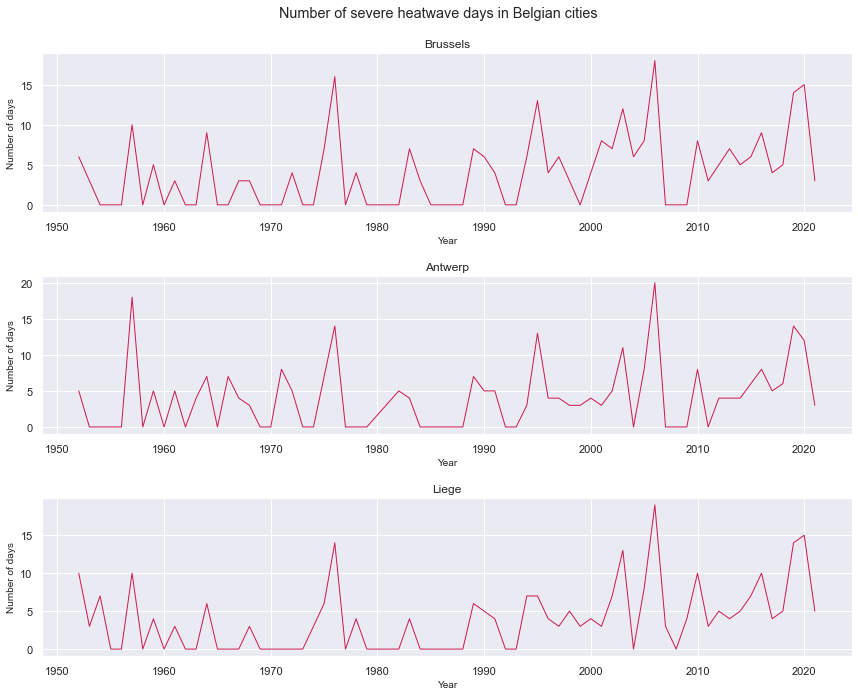

In [42]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9))
fig.tight_layout()
fig.suptitle('Number of severe heatwave days in Belgian cities', y=1.05, fontsize='x-large')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
sns.lineplot(ax=axes[0], data=Bru_count, palette="rocket", linewidth=1, legend=False)
sns.lineplot(ax=axes[1],data=Ant_count, palette="rocket", linewidth=1, legend=False)
sns.lineplot(ax=axes[2],data=Lie_count, palette="rocket", linewidth=1, legend=False)
axes[0].set_xlabel("Year", fontsize = 10)
axes[0].set_ylabel("Number of days", fontsize = 10)
axes[0].set(title='Brussels')
axes[1].set_xlabel("Year", fontsize = 10)
axes[1].set_ylabel("Number of days", fontsize = 10)
axes[1].set(title='Antwerp')
axes[2].set_xlabel("Year", fontsize = 10)
axes[2].set_ylabel("Number of days", fontsize = 10)
axes[2].set(title='Liege')
plt.show()

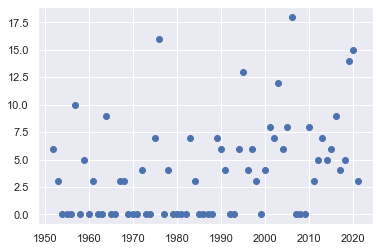

In [43]:
plt.scatter(x=Bru_count.index, y=Bru_count['Severe'])
plt.show()

# Model fitting/selection

**Here we are interested two things: achieve a good fit, and predict the number of heatwaves in coming years well. Thus, it is important not to overfit (use regularization) and check sample performance on the data of last years. On the one hand we need enough points to understand the trend and also enough test data. On the other han we see that the last 20 years there have been more heatwave days. Thus 10 years for the test data is a good compromise.**

In [44]:
Bru_test=Bru_count.tail(10).reset_index().rename(columns={"year": "Year"})
Bru_train=Bru_count.head(Bru_count.size-10).reset_index().rename(columns={"year": "Year"})
Bru_full=Bru_count.reset_index().rename(columns={"year": "Year"})
Ant_full=Ant_count.reset_index().rename(columns={"year": "Year"})
Lie_full=Lie_count.reset_index().rename(columns={"year": "Year"})

**In the following sections we will be carrying out the analysis only for the Brussels dataset as the trend is very similar for other cities too. However, the we will fit the chosen model individually for each city in the end.**

**Data Preprocessing**

In [45]:
def return_summary(model, X_train, X_test, target_train, target_test):
    model.fit(X_train, target_train)
    pred=model.predict(X_train)
    print("Training MAE is: "+ str(mean_absolute_error(target_train, pred)))
    print("Trainig R2 is: "+ str(model.score(X_train, target_train)))
    pred=model.predict(X_test)
    print("Training MAE is: "+ str(mean_absolute_error(target_test, pred)))
    print("Trainig R2 is: "+ str(model.score(X_test, target_test)))

In [46]:
def plot(model, X_train, target_train, title):
    plt.scatter(years, target_train,color='g')
    plt.plot(years, model.predict(X_train),color='b')
    plt.xlabel("Year")
    plt.ylabel("Number of Severe heatwave days")
    plt.title(title)
    plt.show()

In [47]:
standardizer_1=StandardScaler()
standardizer_2=StandardScaler()
trans=PolynomialFeatures(degree=2, include_bias=False)
pipe=Pipeline([('stand_2', standardizer_2),
              ('trans', trans)])
standard_train=standardizer_1.fit_transform(Bru_train['Year'].values.reshape(-1, 1))
standard_test=standardizer_1.transform(Bru_test['Year'].values.reshape(-1, 1))
standard_train_2=pipe.fit_transform(Bru_train['Year'].values.reshape(-1, 1))
standard_test_2=pipe.transform(Bru_test['Year'].values.reshape(-1, 1))
target_train=Bru_train['Severe'].values.reshape(-1, 1)
target_test=Bru_test['Severe'].values.reshape(-1, 1)
years=Bru_train['Year'].values.reshape(-1, 1)

In [48]:
cv=KFold(n_splits=10, shuffle=True, random_state=0)

***First degree Regression model***

Training MAE is: 3.2527093945849157
Trainig R2 is: 0.07427027293433508
Training MAE is: 2.8932536815782166
Trainig R2 is: -0.11667550973476137


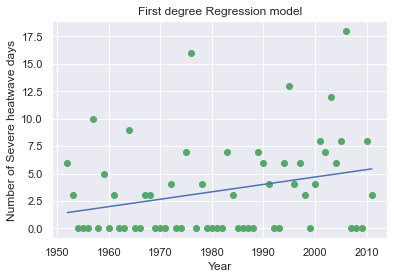

In [49]:
lr=LinearRegression(fit_intercept=True)
lr.fit(standard_train, target_train)
return_summary(lr, standard_train, standard_test, target_train, target_test)
plot(lr, standard_train, target_train, "First degree Regression model")

***Second degree Regression model***

Training MAE is: 3.1952607731126235
Trainig R2 is: 0.09014679633685707
Training MAE is: 3.1523675746043653
Trainig R2 is: 0.06844172801739035


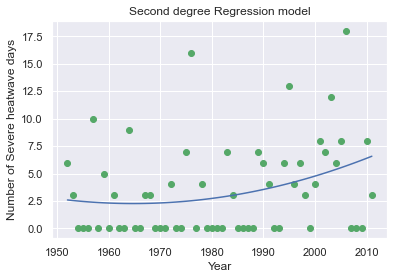

In [50]:
lr_2=LinearRegression(fit_intercept=True)
lr_2.fit(standard_train_2, target_train)
return_summary(lr, standard_train_2, standard_test_2, target_train, target_test)
plot(lr_2, standard_train_2, target_train, "Second degree Regression model")

***First degree Elastic Net***

In [51]:
parameters = {'alpha':np.linspace(0.1, 2, num=20, endpoint=True), 'l1_ratio': np.geomspace(0.000000000001,0.9,20)}
en_1=ElasticNet(fit_intercept=True)
clf = GridSearchCV(en_1, parameters, scoring='neg_mean_absolute_error', cv=cv)
clf.fit(standard_train, target_train)
print(clf.best_estimator_)

ElasticNet(alpha=1.0999999999999999, l1_ratio=1e-12)


As the l1_ratio seems to be small we fit Ridge Regression

***First degree Ridge Regression***

In [52]:
parameters = {'alpha':np.linspace(0, 100, num=1000, endpoint=True)}
ri=Ridge(fit_intercept=True)
clf = GridSearchCV(ri, parameters, scoring='neg_mean_absolute_error', cv=cv)
clf.fit(standard_train, target_train)
print(clf.best_estimator_)

Ridge(alpha=56.95695695695696)


Training MAE is: 3.288535374601786
Trainig R2 is: 0.05665633522771918
Training MAE is: 3.1478152581278285
Trainig R2 is: -0.4413472401046914


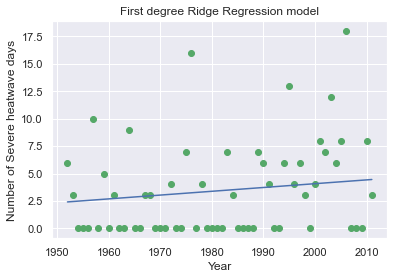

In [53]:
ri=clf.best_estimator_
ri.fit(standard_train, target_train)
return_summary(ri, standard_train, standard_test, target_train, target_test)
plot(ri, standard_train, target_train, "First degree Ridge Regression model")

***Second degree Elastic Net***

In [54]:
parameters = {'alpha':np.linspace(0.1, 2, num=20, endpoint=True), 'l1_ratio': np.geomspace(0.000000000001,0.9,20)}
en_2=ElasticNet(fit_intercept=True)
clf = GridSearchCV(en_2, parameters, scoring='neg_mean_absolute_error', cv=cv)
clf.fit(standard_train_2, target_train)
print(clf.best_estimator_)

ElasticNet(alpha=0.9999999999999999, l1_ratio=1e-12)


As the l1_ratio seems to be small we fit Ridge Regression

***Second degree Ridge Regression***

In [55]:
parameters = {'alpha':np.linspace(0, 100, num=1000, endpoint=True)}
ri_2=Ridge(fit_intercept=True)
clf = GridSearchCV(ri_2, parameters, scoring='neg_mean_absolute_error', cv=cv)
clf.fit(standard_train_2, target_train)
print(clf.best_estimator_)

Ridge(alpha=56.25625625625626)


Training MAE is: 3.2656770903805303
Trainig R2 is: 0.06812959892630499
Training MAE is: 2.8915119931380664
Trainig R2 is: -0.16333156444331354


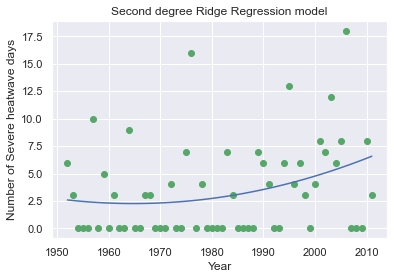

In [56]:
ri_2=clf.best_estimator_
ri_2.fit(standard_train_2, target_train)
return_summary(ri_2, standard_train_2, standard_test_2, target_train, target_test)
plot(lr_2, standard_train_2, target_train, "Second degree Ridge Regression model")

As there are some points that could be considered outliers, we will try fitting Huber Regression. The idea behind it is instead of minimizing SSE, it minimizes Huber loss which consists of absolute error for the outliers instead of the quadratic. The tolerance level is defined by epsilon and it also has regularization term alpha. We will tune these using cross validation.

***First degree Huber Regression***

In [57]:
parameters = {'epsilon':np.linspace(1.1, 4, num=20, endpoint=True), 'alpha':np.linspace(0, 10, num=30, endpoint=True)}
hr_1=HuberRegressor(fit_intercept=True)
clf = GridSearchCV(hr_1, parameters, scoring='neg_mean_absolute_error', cv=cv)
clf.fit(standard_train, target_train.ravel())
print(clf.best_estimator_)

HuberRegressor(alpha=0.0, epsilon=1.2526315789473685)


Training MAE is: 3.1621275137350526
Trainig R2 is: 0.041028012484593535
Training MAE is: 2.9509685877517855
Trainig R2 is: -0.2827307501984804


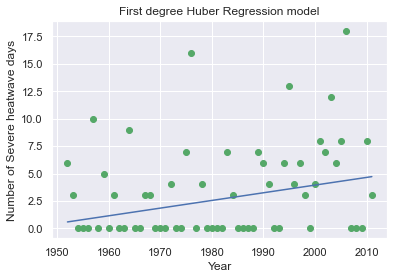

In [58]:
hr_1=clf.best_estimator_
hr_1.fit(standard_train, target_train.ravel())
return_summary(hr_1, standard_train, standard_test, target_train.ravel(), target_test.ravel())
plot(hr_1, standard_train, target_train, "First degree Huber Regression model")

***Second degree Huber Regression***

In [59]:
parameters = {'epsilon':np.linspace(1.1, 4, num=20, endpoint=True), 'alpha':np.linspace(0, 10, num=30, endpoint=True)}
hr_2=HuberRegressor(fit_intercept=True)
clf = GridSearchCV(hr_2, parameters, scoring='neg_mean_absolute_error', cv=cv)
clf.fit(standard_train_2, target_train.ravel())
print(clf.best_estimator_)

HuberRegressor(alpha=0.0, epsilon=1.1)


Training MAE is: 3.0031575356070475
Trainig R2 is: -0.034015394143079636
Training MAE is: 4.11369864114309
Trainig R2 is: -0.42853955992279835


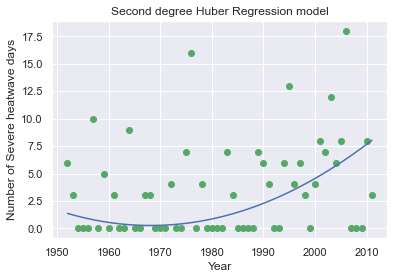

In [60]:
hr_2=clf.best_estimator_
hr_2.fit(standard_train_2, target_train.ravel())
return_summary(hr_2, standard_train_2, standard_test_2, target_train.ravel(), target_test.ravel())
plot(hr_2, standard_train_2, target_train, "Second degree Huber Regression model")

By looking at the plot we can see that there is a possibility of having a bigger error variance when we increase the year. As we the number of severe heatwave days is a count data, it might be reasonable to try Poisson GLM. 

***First degree Poisson Regression***

In [61]:
parameters = {'alpha':np.linspace(0, 10, num=30, endpoint=True)}
pr_1=PoissonRegressor(fit_intercept=True)
clf = GridSearchCV(pr_1, parameters, scoring='neg_mean_absolute_error', cv=cv)
clf.fit(standard_train, target_train.ravel())
print(clf.best_estimator_)

PoissonRegressor(alpha=3.793103448275862)


Training MAE is: 3.2894173690088655
Trainig R2 is: 0.05242888116583455
Training MAE is: 3.121951730884674
Trainig R2 is: -0.6050388496095493


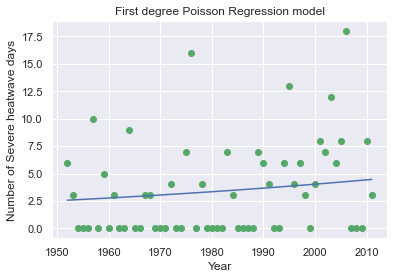

In [62]:
pr_1=clf.best_estimator_
pr_1.fit(standard_train, target_train.ravel())
return_summary(pr_1, standard_train, standard_test, target_train.ravel(), target_test.ravel())
plot(pr_1, standard_train, target_train, "First degree Poisson Regression model")

***Second degree Poisson Regression***

In [63]:
parameters = {'alpha':np.linspace(0, 10, num=30, endpoint=True)}
pr_2=PoissonRegressor(fit_intercept=True)
clf = GridSearchCV(pr_2, parameters, scoring='neg_mean_absolute_error', cv=cv)
clf.fit(standard_train_2, target_train.ravel())
print(clf.best_estimator_)

PoissonRegressor(alpha=4.137931034482759)


Training MAE is: 3.2777935497773516
Trainig R2 is: 0.058417435281283736
Training MAE is: 2.8910186243071623
Trainig R2 is: -0.15807514370147246


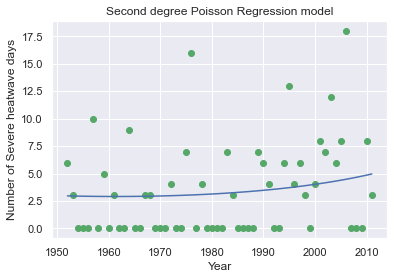

In [64]:
pr_2=clf.best_estimator_
pr_2.fit(standard_train_2, target_train.ravel())
return_summary(pr_2, standard_train_2, standard_test_2, target_train.ravel(), target_test.ravel())
plot(pr_2, standard_train_2, target_train, "Second degree Poisson Regression model")

$$Summary$$

| Model | Training MAE   | Test MAE |
|------|------|------|
|   First Degree Linear Regression  | 3.2527 | 2.8932 |
|   Second Degree Linear Regression  | 3.1952 | 3.1523 |
|   First Degree Ridge Regression  | 3.2885 | 2.1478 |
|   Second Degree Ridge Regression  | 3.2656 | 2.8915 |
|   First Degree Huber Regression  | 3.1621 | 2.9509 |
|   Second Degree Huber Regression  | 3.0031 | 4.1136 |
|   First Degree Poisson Regression  | 3.2894 | 3.1219 |
|   Second Degree Poisson Regression  | 3.2777 | 2.8910 |

*We see that the Second Huber Regression has the smallest MAE for the training. So, we choose this model for predictions. However, it does not generalize will for the test set. Thas comes at no surprise as it was trained by giving small weight to outliers. If we want to include outliers as usual observations in our predictions, Second Degree Linear Regression seems to be a good choice with the smallest training MAE and reasonable test MAE that generalizes well. Thus, the user will be given average predicition that takes into account the possible outliers in the future, and that does not take into account.*

# Historical EHF plot and prediction

In [65]:
Bru_summer['Date']=Bru_summer.index.get_level_values(0).astype(str) + '/' + Bru_summer.index.get_level_values(1).astype(str) + '/' + Bru_summer.index.get_level_values(2).astype(str)
Ant_summer['Date']=Ant_summer.index.get_level_values(0).astype(str) + '/' + Ant_summer.index.get_level_values(1).astype(str) + '/' + Ant_summer.index.get_level_values(2).astype(str)
Lie_summer['Date']=Lie_summer.index.get_level_values(0).astype(str) + '/' + Lie_summer.index.get_level_values(1).astype(str) + '/' + Lie_summer.index.get_level_values(2).astype(str)

In [66]:
Bru_summer=Bru_summer.loc[:, 6:9, :]
Ant_summer=Ant_summer.loc[:, 6:9, :]
Lie_summer=Lie_summer.loc[:, 6:9, :]

In [67]:
Bru_summer=Bru_summer[Bru_summer['EHF'].notna()]
Ant_summer=Ant_summer[Ant_summer['EHF'].notna()]
Lie_summer=Lie_summer[Lie_summer['EHF'].notna()]

In [68]:
def ehf_plot(location, year):
    try:
        if not isinstance(location, str):
            print("Location has to be a string")
            print("Please select on of the cities: Brussels, Antwerp, Liege")
            return None
        if not isinstance(year, int):
            print("A year has to be an integer number")
            return None
        if location=="Brussels":
            ehi=EHI_85_Bru
            city=Bru_summer
        elif location=="Antwerp":
            ehi=EHI_85_Ant
            city=Ant_summer
        elif location=="Liege":
            ehi=EHI_85_Lie
            city=Lie_summer
        else:
            print("Please select on of the cities: Brussels, Antwerp, Liege")
            return None
        pal = sns.color_palette("YlOrBr", len(city.loc[year, :, :]))
        rank = city.loc[year, :, :]['EHF'].argsort().argsort()
        fig, ax = plt.subplots(figsize=(15,5))
        barplot=sns.barplot(ax=ax, x='Date', y='EHF',  data=city.loc[year, :, :], palette=np.array(pal)[rank])
        for index, label in enumerate(barplot.get_xticklabels()):
            if index % 4 == 0:
                label.set_visible(True)
            else:
                label.set_visible(False)
        plt.xticks(rotation=30, size = 9)
        ax.axhline(ehi, ls='--', color='r')
        ax.text(0.25,ehi+1, "Severe Heatwave", size=10)
        ax.axhline(3*ehi, ls='--', color='r')
        ax.text(0.25,3*ehi+1, "Extreme Heatwave", size=10)
        plt.show()
    except:
        print("We do not have enough data for" + location + "in given year")
        

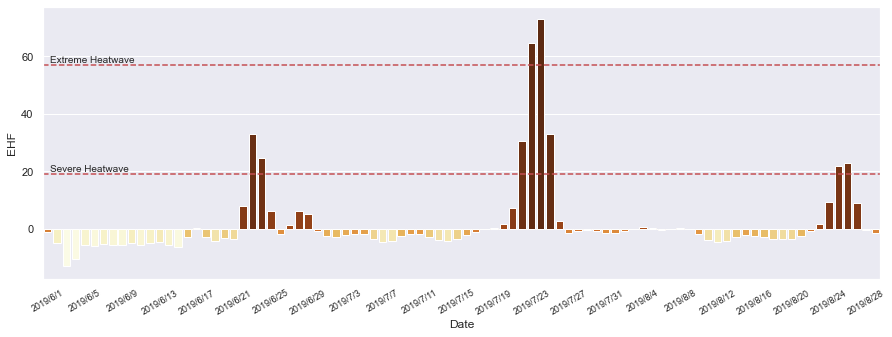

In [69]:
ehf_plot("Antwerp", 2019)

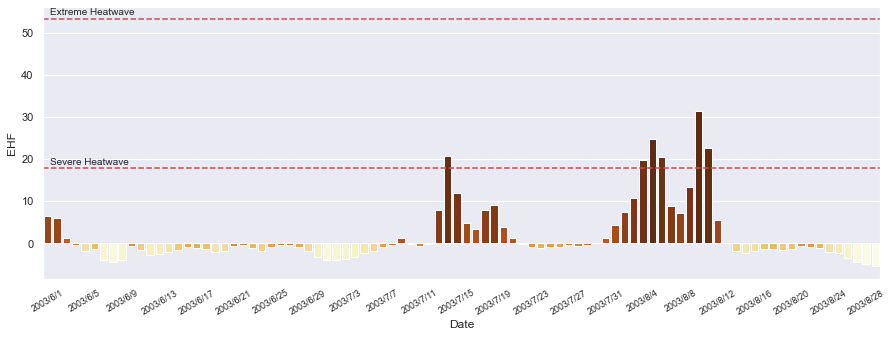

In [70]:
ehf_plot("Brussels", 2003)

In [71]:
def predictions(location, year):
    try:
        if not isinstance(location, str):
            print("Location has to be a string")
            print("Please select on of the cities: Brussels, Antwerp, Liege")
            return None
        if not isinstance(year, int):
            print("A year has to be an integer number")
            return None
        if year<2021:
            print("Select a year which is in future, for past years you can use ehf_plot function")
            return None
        if year>2050:
            print('Predicition horizon is too far, showing only until 2040')
            year=2040
        if location=="Brussels":
            city=Bru_full
        elif location=="Antwerp":
            city=Ant_full
        elif location=="Liege":
            city=Lie_full
        else:
            print("Please select on of the cities: Brussels, Antwerp, Liege")
            return None
        standardizer_2=StandardScaler()
        trans=PolynomialFeatures(degree=2, include_bias=False)
        pipe=Pipeline([('stand_2', standardizer_2),
                       ('trans', trans)])
        hr_2=HuberRegressor(fit_intercept=True, alpha=4.137931034482759, epsilon=3.8473684210526318)
        hr_2.fit(pipe.fit_transform(city['Year'].values.reshape(-1, 1)), city['Severe'])
        huber_pred=hr_2.predict(pipe.transform(np.arange(2021, year+1).reshape(-1, 1)))
        lr_2=LinearRegression(fit_intercept=True)
        lr_2.fit(pipe.fit_transform(city['Year'].values.reshape(-1, 1)), city['Severe'])
        linreg_pred=lr_2.predict(pipe.transform(np.arange(2021, year+1).reshape(-1, 1)))
        df=pd.DataFrame(data={'Year':np.arange(2021, year+1), 'Exluding the possible outliers':huber_pred, 'Including the possible outliers':linreg_pred})
        print('\n')
        print("Predictions for the number of heatwave days in "+location+" until " +str(year))
        print('\n')
        print(df.to_string(index=False))
        if year>2040:
            print("\n")
            print("Predictions beyond 2040 might not be reliable")
    except:
        print("Unknown error")
        
        

In [72]:
predictions("Liege", 2030)



Predictions for the number of heatwave days in Liege until 2030


 Year  Exluding the possible outliers  Including the possible outliers
 2021                        8.412607                         9.558216
 2022                        8.681008                         9.897771
 2023                        8.955152                        10.244674
 2024                        9.235040                        10.598925
 2025                        9.520673                        10.960523
 2026                        9.812049                        11.329468
 2027                       10.109170                        11.705762
 2028                       10.412035                        12.089402
 2029                       10.720643                        12.480391
 2030                       11.034996                        12.878727


In [73]:
predictions("Brussels", 2060)

Predicition horizon is too far, showing only until 2040


Predictions for the number of heatwave days in Brussels until 2040


 Year  Exluding the possible outliers  Including the possible outliers
 2021                        7.500635                         8.415258
 2022                        7.673184                         8.635550
 2023                        7.848719                         8.859725
 2024                        8.027240                         9.087782
 2025                        8.208747                         9.319723
 2026                        8.393240                         9.555547
 2027                        8.580719                         9.795254
 2028                        8.771184                        10.038844
 2029                        8.964635                        10.286317
 2030                        9.161072                        10.537673
 2031                        9.360495                        10.792912
 2032                